In [1]:
# Proof of concept implementation

In [2]:
from pytorch_pretrained_vit import ViT
import json
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import cv2
import png

In [6]:
# Load data
#img = Image.open('img.jpg')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

testset = torchvision.datasets.ImageFolder(root='./data/test/', transform=transform)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
img = Image.open('img.jpg')

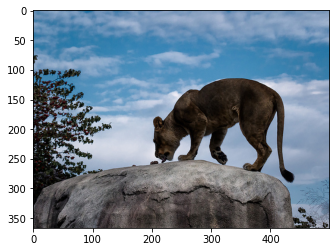

plane


In [10]:
import matplotlib.pyplot as plt
import numpy as np


# Show image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
image, label = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(image))
#print labels
print(' '.join('%5s' % classes[label[j]] for j in range(batch_size)))

In [ ]:
# Load pretrained Vision Transformer
model = ViT('B_16_imagenet1k', pretrained=True)

In [ ]:
# Object detection
detector_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).autoshape()
results = detector_model(img, size=640)
results.print()
results.show()

In [ ]:
# Get bounding box coordinates from detection
x1 = int(results.xyxy[0][0][0])
y1 = int(results.xyxy[0][0][1])
x2 = int(results.xyxy[0][0][2])
y2 = int(results.xyxy[0][0][3])
bbox_points=[x1, y1, x2, y2]
print('bounding box is:', x1, y1, x2, y2)

In [ ]:
# Show cropped image (bounding box)
cropped_img = img.crop((x1, y1, x2, y2))
cropped_img.show()
type(cropped_img)

In [ ]:
# Preprocess image for transformer
tfms = transforms.Compose([transforms.Resize(model.image_size), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),])
preprocessed_image = tfms(cropped_img).unsqueeze(0)

In [ ]:
# Segmentation
# Code adapted from https://github.com/spmallick/learnopencv/blob/master/app-seperation-semseg/Background-Removal.py
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2


# %matplotlib.use('TkAgg')

# Apply the transformations needed
import torchvision.transforms as T

# Define the helper function
def decode_segmap(image, source, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])
  
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  
  rgb = np.stack([r, g, b], axis=2)

  # Load the foreground input image 
  foreground = source

  # Change the color of foreground image to RGB 
  # and resize image to match shape of R-band in RGB output map
  #foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(np.array(foreground),(r.shape[1],r.shape[0]))

  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)  
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)  
  
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)

  # Return a normalized output image for display
  return outImage/255

def segment(net, image, show_orig=True, dev='cpu'):
  img = image
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  rgb = decode_segmap(om, img)
    
  plt.imshow(rgb); plt.axis('off'); plt.show()

  plt.savefig(fname='seg_result')

In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
segment(dlab, cropped_img, show_orig=False)
segmented_img = Image.open('seg_result.png').convert('RGB')
segmented_img.show()

In [ ]:
# Preprocess image for transformer
tfms = transforms.Compose([transforms.Resize(model.image_size), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),])
preprocessed_image = tfms(segmented_img).unsqueeze(0)

In [ ]:
# Load class labels
labels_map = json.load(open('labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]

In [ ]:
# Classify
model.eval()
with torch.no_grad():
    outputs = model(preprocessed_image).squeeze(0)
print('-----')  
for idx in torch.topk(outputs, k=3).indices.tolist():
    prob = torch.softmax(outputs, -1)[idx].item()
    print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))